In [4]:
import os
import warnings
from datetime import datetime, timedelta
from typing import Tuple

import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from prometheus_api_client import MetricSnapshotDataFrame, MetricRangeDataFrame, PrometheusConnect
from prometheus_api_client.utils import parse_datetime
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5


warnings.filterwarnings('ignore')


load_dotenv()

True

In [5]:
class BtalertIA:
    def __init__(self, last_minutes_importance: int, regressor=None) -> None:
        """
        Args:
            last_minutes_importance (int): The last minutes that matter to foreacasting (context)
        """
        self.prom = PrometheusConnect(
            url=os.getenv('PROMETHEUS_URL'), disable_ssl=True)
        self.regressor = regressor
        if regressor is None:
            self.regressor = RandomForestRegressor(
                max_depth=40,
                n_estimators=3,
                random_state=123,
            )
        self.forecaster = ForecasterAutoreg(
            regressor=self.regressor,
            lags=self.minutes_to_step(last_minutes_importance)
        )
        self.original_dataframe = pd.DataFrame()
        self.data_train = pd.DataFrame()
        self.data_test = pd.DataFrame()
        self.predictions = pd.Series()
        self.value_column = 'value'
        self.timestamp_column = 'timestamp'

    def load_metric_as_dataframe(self, start: str, end: str, metric_name: str, alias: str) -> pd.DataFrame:
        start_time = parse_datetime(start)
        end_time = parse_datetime(end)
        original_dataframe = MetricRangeDataFrame(
            self.prom.custom_query_range(
                query=metric_name, start_time=start_time, end_time=end_time, step=15)
        )[['value']]

        original_dataframe[self.value_column] = [
            float(value) for value in original_dataframe[self.value_column]]
        
        original_dataframe.rename(columns={'value': alias}, inplace=True)
        self.value_column = alias

        self.original_dataframe = original_dataframe
        return original_dataframe

    def split_test_train_dataframe(self, minutes_split: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
        steps = self.minutes_to_step(minutes_split)

        self.data_train = self.original_dataframe[:-steps]
        self.data_test = self.original_dataframe[-steps:]

        return self.data_train, self.data_test

    def minutes_to_step(self, min: int) -> int:
        return int((min * 60) / 15)

    def train_model(self) -> None:
        self.forecaster.fit(y=self.data_train[self.value_column])

    def predict(self, minutes_prediction: int) -> pd.Series:
        self.predictions = self.forecaster.predict(steps=self.minutes_to_step(minutes_prediction))
        return self.predictions

    def plot_graphic(self):
        fig, ax = plt.subplots(figsize=(18, 12))
        self.data_train[self.value_column].plot(ax=ax, label='train')
        self.data_test[self.value_column].plot(ax=ax, label='test')
        self.predictions.plot(ax=ax, label='predictions')
        ax.legend()

    def get_mean_squared_error(self) -> float:
        error_mse: float = mean_squared_error(
            y_true=self.data_test[self.value_column],
            y_pred=self.predictions
        )
        return error_mse

    def execute(self, start: str, end: str, metric_name: str, minutes_split: int, minutes_prediction: int, alias: str):
        self.load_metric_as_dataframe(start, end, metric_name, alias)
        self.split_test_train_dataframe(minutes_split)
        self.train_model()
        self.predict(minutes_prediction)
# consts
#start = '2022-05-11 07:50:07'
end = '2022-05-11 10:47:27'
start = '2022-05-11 09:53:16'
#end = '2022-05-11 08:03:53'
min_split = 25
# teste
req_failed_ia = BtalertIA(20)

In [6]:
start_time = parse_datetime(start)
end_time = parse_datetime(end)
original_dataframe = MetricRangeDataFrame(
            req_failed_ia.prom.custom_query_range(
                query='btalert_failed_requests_percent', start_time=start_time, end_time=end_time, step=15)
        )[['value']]
original_dataframe['value'] = [float(v) for v in original_dataframe['value']]
original_dataframe.plot()

urllib3.connectionpool WARNING Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002255C9AC908>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it')': /api/v1/query_range?query=btalert_failed_requests_percent&start=1652273596&end=1652276847&step=15
urllib3.connectionpool WARNING Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002255C9718C8>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it')': /api/v1/query_range?query=btalert_failed_requests_percent&start=1652273596&end=1652276847&step=15
urllib3.connectionpool WARNING Retrying (Retry(total=0, connect=None, read=None, redirec

ConnectionError: HTTPConnectionPool(host='localhost', port=9090): Max retries exceeded with url: /api/v1/query_range?query=btalert_failed_requests_percent&start=1652273596&end=1652276847&step=15 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002255C9A3448>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

In [ ]:
req_failed_ia.original_dataframe['t'] = [datetime.fromtimestamp(tt) for tt in req_failed_ia.original_dataframe.index]
req_failed_ia.original_dataframe['t'] = req_failed_ia.original_dataframe['t'].astype('datetime64[s]')
print(req_failed_ia.original_dataframe['t'])
req_failed_ia.original_dataframe.set_index(req_failed_ia.original_dataframe['t'])
req_failed_ia.original_dataframe.drop(columns='t')
req_failed_ia.original_dataframe.head()

In [7]:
#req_failed_ia.load_metric_as_dataframe(start, end, 'btalert_failed_requests_percent', 'requests_failed')
#req_failed_ia.value_column = 'requests_failed'
#req_failed_ia.split_test_train_dataframe(min_split)
#req_failed_ia.train_model()
#req_failed_ia.predict(5)
#req_failed_ia.plot_graphic()
req_failed_ia = BtalertIA(10)
req_failed_ia.execute(start, end, 'btalert_failed_requests_percent', 10, 25, 'requests_failed')
req_failed_ia.plot_graphic()

urllib3.connectionpool WARNING Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002255C9A20C8>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it')': /api/v1/query_range?query=btalert_failed_requests_percent&start=1652273596&end=1652276847&step=15
urllib3.connectionpool WARNING Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002255C97E588>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it')': /api/v1/query_range?query=btalert_failed_requests_percent&start=1652273596&end=1652276847&step=15
urllib3.connectionpool WARNING Retrying (Retry(total=0, connect=None, read=None, redirec

ConnectionError: HTTPConnectionPool(host='localhost', port=9090): Max retries exceeded with url: /api/v1/query_range?query=btalert_failed_requests_percent&start=1652273596&end=1652276847&step=15 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002255C9DAB48>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

In [10]:
req_failed = req_failed_ia.load_metric_as_dataframe(start, end, 'btalert_failed_requests_percent', 'req_failed')
requests_per_second = req_failed_ia.load_metric_as_dataframe(start, end, 'btalert_requests_per_second', 'request_per_sec')
#pg_lock_count = req_failed_ia.load_metric_as_dataframe(start, end, 'pg_lock_count')
max_cpu = req_failed_ia.load_metric_as_dataframe(start, end, 'max(rate(container_cpu_usage_seconds_total{image="api6-backend_cadastrol-server"}[1m:15s]))', 'cpu_percent')
memory = req_failed_ia.load_metric_as_dataframe(start, end, 'container_memory_rss{name="cadastrol-server"} / container_spec_memory_limit_bytes{name="cadastrol-server"}', 'memory_percent')

urllib3.connectionpool WARNING Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002255CA6F948>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it')': /api/v1/query_range?query=btalert_failed_requests_percent&start=1652273596&end=1652276847&step=15
urllib3.connectionpool WARNING Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002255CA72248>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it')': /api/v1/query_range?query=btalert_failed_requests_percent&start=1652273596&end=1652276847&step=15
urllib3.connectionpool WARNING Retrying (Retry(total=0, connect=None, read=None, redirec

ConnectionError: HTTPConnectionPool(host='localhost', port=9090): Max retries exceeded with url: /api/v1/query_range?query=btalert_failed_requests_percent&start=1652273596&end=1652276847&step=15 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002255CA774C8>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

In [11]:
res = pd.concat([req_failed, requests_per_second, max_cpu, memory], axis=1)
res.head(10)

NameError: name 'req_failed' is not defined

In [9]:
res.to_csv('dados.csv', sep=';', encoding='utf-8')

NameError: name 'res' is not defined

In [29]:
cor = res.corr()
cor

,req_failed,request_per_sec,cpu_percent,memory_percent
req_failed,1.000000,-0.648486,-0.497337,-0.504827
request_per_sec,-0.648486,1.000000,0.902064,0.367997
cpu_percent,-0.497337,0.902064,1.000000,0.340265
memory_percent,-0.504827,0.367997,0.340265,1.000000


<AxesSubplot:>

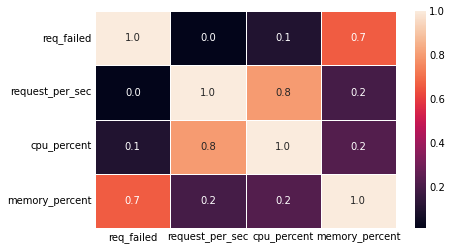

In [24]:
import seaborn as sn
plot = sn.heatmap(cor, annot=True, fmt='0.1f', linewidths=.6)
plot

<AxesSubplot:>

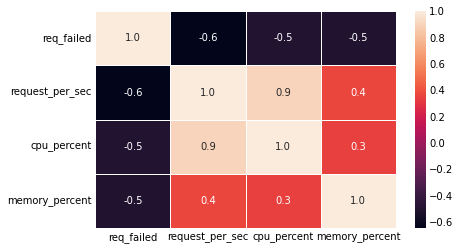

In [30]:
plot = sn.heatmap(cor, annot=True, fmt='0.1f', linewidths=.6)
plot

In [2]:
dados = pd.read_csv('dados.csv', delimiter=';')

In [3]:
dados['timestamp'] = [datetime.fromtimestamp(timestamp) for timestamp in dados['timestamp']]

In [4]:
dados = dados.set_index(dados['timestamp'])
dados = dados.asfreq(freq='15S', method='bfill')

In [9]:
dados.isnull()
dados.fillna(0, inplace=True)
dados.isnull()

,timestamp,req_failed,request_per_sec,cpu_percent,memory_percent
timestamp,,,,,
2022-05-11 07:50:07,False,False,False,False,False
2022-05-11 07:50:22,False,False,False,False,False
2022-05-11 07:50:37,False,False,False,False,False
2022-05-11 07:50:52,False,False,False,False,False
2022-05-11 07:51:07,False,False,False,False,False
...,...,...,...,...,...
2022-05-11 10:46:07,False,False,False,False,False
2022-05-11 10:46:22,False,False,False,False,False
2022-05-11 10:46:37,False,False,False,False,False


In [10]:
dados

,timestamp,req_failed,request_per_sec,cpu_percent,memory_percent
timestamp,,,,,
2022-05-11 07:50:07,2022-05-11 07:50:07,0.00,0.00,0.000286,0.681229
2022-05-11 07:50:22,2022-05-11 07:50:22,0.00,0.80,0.022767,0.740280
2022-05-11 07:50:37,2022-05-11 07:50:37,0.00,12.07,0.065587,0.783585
2022-05-11 07:50:52,2022-05-11 07:50:52,0.00,15.27,0.116834,0.881149
2022-05-11 07:51:07,2022-05-11 07:51:07,0.00,20.93,0.172781,0.863525
...,...,...,...,...,...
2022-05-11 10:46:07,2022-05-11 10:46:07,99.98,0.00,0.000000,0.000000
2022-05-11 10:46:22,2022-05-11 10:46:22,99.98,0.00,0.000000,0.000000
2022-05-11 10:46:37,2022-05-11 10:46:37,99.98,0.00,0.000000,0.000000


In [8]:
def minutes_to_step(min: int) -> int:
        return int((min * 60) / 15)

regressor = RandomForestRegressor(
                max_depth=20,
                n_estimators=3,
                random_state=123,
            )

forecaster = ForecasterAutoreg(
            regressor=regressor,
            lags=minutes_to_step(30)
        )

In [16]:
dados = dados.drop(columns='timestamp')

<AxesSubplot:xlabel='timestamp'>

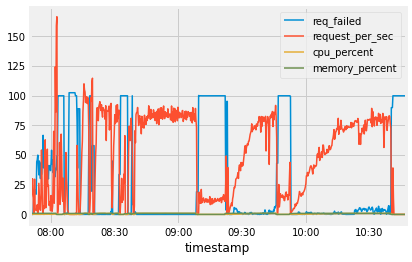

In [18]:
fig, ax = plt.subplots(figsize=(18, 12))
dados['req_failed'].plot(ax=ax, label='req_failed')
dados['req_failed'].plot(ax=ax, label='req_failed')
dados['req_failed'].plot(ax=ax, label='req_failed')
dados['req_failed'].plot(ax=ax, label='req_failed')

ax.legends()
#dados.plot()